Step 1: Load and prepare data

In [20]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('crypto_data.csv')

# Calculate log changes (log-returns) for forecasting
df['Log_Close'] = np.log(df['Close'])
df['Log_Change'] = df['Log_Close'].diff()  # Target variable

# Drop NaN values that may appear due to diff()
df = df.dropna()

# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Display first few rows
df.head()

,Timestamp,Open,High,Low,Close,Volume,Log_Close,Log_Change
1,2019-01-01 00:15:00,3697.91,3698.75,3690.56,3694.20,131.742721,8.214519,-0.000842
2,2019-01-01 00:30:00,3693.96,3705.00,3693.00,3702.39,171.877714,8.216734,0.002215
3,2019-01-01 00:45:00,3702.05,3713.00,3695.02,3700.31,191.772890,8.216172,-0.000562
4,2019-01-01 01:00:00,3700.20,3702.73,3691.22,3701.03,139.872706,8.216366,0.000195
5,2019-01-01 01:15:00,3702.39,3702.39,3695.46,3699.25,135.318759,8.215885,-0.000481


Step 2: STL Decomposition

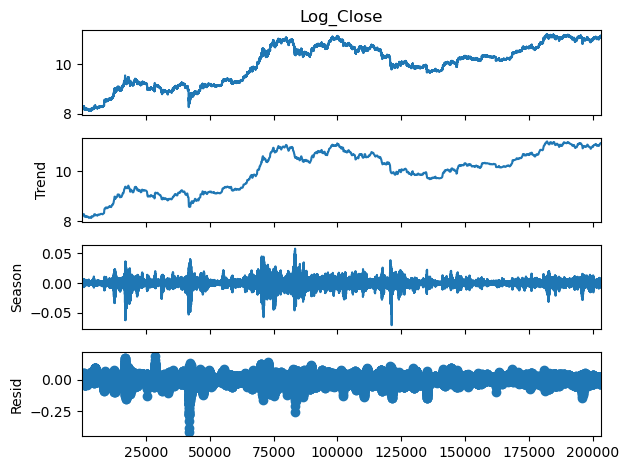

In [21]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

def add_stl_features(df): 
    # STL decomposition
    seasonal_period = 96  # 15-minute intervals in a day (96 intervals in 24 hours)
    stl = STL(df['Log_Close'], period=seasonal_period, robust=True)
    result = stl.fit()

    # Add STL components to the dataframe
    df['STL_Trend'] = result.trend
    df['STL_Seasonal'] = result.seasonal
    df['STL_Residual'] = result.resid

    # Plot STL components
    result.plot()
    plt.show()

    return df

df = add_stl_features(df)

Step 3: Split data

In [22]:
train_start, train_end = '2019-01-02', '2024-01-01'
valid_start, valid_end = '2024-01-02', '2024-04-01'
predict_start, predict_end = '2024-04-02', '2024-10-20'

# Split the dataset
train_df = df[(df['Timestamp'] >= train_start) & (df['Timestamp'] <= train_end)]
valid_df = df[(df['Timestamp'] >= valid_start) & (df['Timestamp'] <= valid_end)]
predict_df = df[(df['Timestamp'] >= predict_start) & (df['Timestamp'] <= predict_end)]

Step 4: Feature Engineering

In [23]:
def add_lag_features(df, lags):
    """
    Add lag-based features to the dataframe.
    Args:
        df (pd.DataFrame): Dataframe to add features to.
        lags (list): List of lag intervals.

    Returns:
        pd.DataFrame: Dataframe with additional features.
    """
    for lag in lags:
        df[f'log_close/mean_{lag}'] = np.log(df['Close'] / 
                                             np.roll(df['Close'].rolling(lag).mean(), lag))
        df[f'log_return_{lag}'] = np.log(df['Close'] / np.roll(df['Close'], lag))

    for lag in lags:
        df[f'mean_close/mean_{lag}'] = df[[f'log_close/mean_{lag}']].mean(axis=1)
        df[f'mean_log_returns_{lag}'] = df[[f'log_return_{lag}']].mean(axis=1)
        
    for lag in lags:
        df[f'log_close/mean_{lag}-mean_close/mean_{lag}'] = df[f'log_close/mean_{lag}'] - df[f'mean_close/mean_{lag}']
        df[f'log_return_{lag}-mean_log_returns_{lag}'] = df[f'log_return_{lag}'] - df[f'mean_log_returns_{lag}']

    return df

# Apply feature engineering to train, validation, and prediction sets
lags = [10, 20, 50]
train_df = add_lag_features(train_df, lags)
valid_df = add_lag_features(valid_df, lags)
predict_df = add_lag_features(predict_df, lags)

C:\Users\kyo\AppData\Local\Temp\ipykernel_9424\2409719024.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'log_close/mean_{lag}'] = np.log(df['Close'] /
C:\Users\kyo\AppData\Local\Temp\ipykernel_9424\2409719024.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'log_return_{lag}'] = np.log(df['Close'] / np.roll(df['Close'], lag))
C:\Users\kyo\AppData\Local\Temp\ipykernel_9424\2409719024.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [35]:
def add_ta_features(df):
    """
    Add technical analysis (TA) features to a DataFrame.
    Args:
        df (pd.DataFrame): DataFrame with columns ['Close', 'High', 'Low'] (and optionally 'Volume']).
    
    Returns:
        pd.DataFrame: DataFrame with added TA features.
    """
    # Ensure Close, High, and Low columns exist
    if not all(col in df.columns for col in ['Close', 'High', 'Low']):
        raise ValueError("DataFrame must contain 'Close', 'High', and 'Low' columns.")
    
    # Relative Strength Index (RSI)
    def calculate_rsi(prices, period=14):
        delta = prices.diff()
        gain = np.where(delta > 0, delta, 0)
        loss = np.where(delta < 0, -delta, 0)
        avg_gain = pd.Series(gain).rolling(window=period).mean()
        avg_loss = pd.Series(loss).rolling(window=period).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    # Moving Average Convergence Divergence (MACD)
    def calculate_macd(prices, fast_period=12, slow_period=26, signal_period=9):
        ema_fast = prices.ewm(span=fast_period, adjust=False).mean()
        ema_slow = prices.ewm(span=slow_period, adjust=False).mean()
        macd = ema_fast - ema_slow
        signal = macd.ewm(span=signal_period, adjust=False).mean()
        histogram = macd - signal
        return macd, signal, histogram

    # Bollinger Bands
    def calculate_bollinger_bands(prices, period=20, num_std=2):
        sma = prices.rolling(window=period).mean()
        std = prices.rolling(window=period).std()
        upper_band = sma + (num_std * std)
        lower_band = sma - (num_std * std)
        return upper_band, sma, lower_band

    # Average True Range (ATR)
    def calculate_atr(high, low, close, period=14):
        tr = np.maximum.reduce([
            high - low,
            np.abs(high - close.shift(1)),
            np.abs(low - close.shift(1))
        ])
        atr = pd.Series(tr).rolling(window=period).mean()
        return atr

    # Exponential Moving Average (EMA)
    def calculate_ema(prices, period):
        return prices.ewm(span=period, adjust=False).mean()

    # Simple Moving Averages (SMA)
    def calculate_sma(prices, period):
        return prices.rolling(window=period).mean()

    # Stochastic Oscillator
    def calculate_stochastic_oscillator(close, high, low, period=14):
        lowest_low = low.rolling(window=period).min()
        highest_high = high.rolling(window=period).max()
        k = 100 * (close - lowest_low) / (highest_high - lowest_low)
        d = k.rolling(window=3).mean()
        return k, d

    # On-Balance Volume (OBV)
    def calculate_obv(close, volume):
        return (np.sign(close.diff()) * volume).fillna(0).cumsum()

    # Average Directional Index (ADX)
    def calculate_adx(high, low, close, period=14):
        plus_dm = np.where(high.diff() > low.diff(), np.maximum(high.diff(), 0), 0)
        minus_dm = np.where(low.diff() > high.diff(), np.maximum(low.diff(), 0), 0)
        tr = np.maximum.reduce([
            high - low,
            np.abs(high - close.shift(1)),
            np.abs(low - close.shift(1))
        ])
        atr = pd.Series(tr).rolling(window=period).mean()
        plus_di = 100 * (pd.Series(plus_dm).rolling(window=period).mean() / atr)
        minus_di = 100 * (pd.Series(minus_dm).rolling(window=period).mean() / atr)
        dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
        adx = pd.Series(dx).rolling(window=period).mean()
        return adx, plus_di, minus_di

    # Add TA features to the DataFrame
    df['RSI'] = calculate_rsi(df['Close'])
    df['MACD'], df['MACD_Signal'], df['MACD_Histogram'] = calculate_macd(df['Close'])
    df['BB_Upper'], df['BB_Middle'], df['BB_Lower'] = calculate_bollinger_bands(df['Close'])
    df['EMA_50'] = calculate_ema(df['Close'], period=50)
    df['EMA_200'] = calculate_ema(df['Close'], period=200)
    df['ATR'] = calculate_atr(df['High'], df['Low'], df['Close'])
    df['SMA_20'] = calculate_sma(df['Close'], period=20)
    df['SMA_50'] = calculate_sma(df['Close'], period=50)
    df['Stochastic_%K'], df['Stochastic_%D'] = calculate_stochastic_oscillator(df['Close'], df['High'], df['Low'])
    df['OBV'] = calculate_obv(df['Close'], df['Volume'])
    df['ADX'], df['+DI'], df['-DI'] = calculate_adx(df['High'], df['Low'], df['Close'])

    # Return the DataFrame with added features
    return df

train_df = add_ta_features(train_df)
valid_df = add_ta_features(valid_df)
predict_df = add_ta_features(predict_df)

C:\Users\kyo\AppData\Local\Temp\ipykernel_9424\3897624095.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RSI'] = calculate_rsi(df['Close'])
C:\Users\kyo\AppData\Local\Temp\ipykernel_9424\3897624095.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MACD'], df['MACD_Signal'], df['MACD_Histogram'] = calculate_macd(df['Close'])
C:\Users\kyo\AppData\Local\Temp\ipykernel_9424\3897624095.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Step 5: Train LightGBM Model

In [36]:
import lightgbm as lgb

# Define features and target variable
features = ['Volume', 'Open', 'Close', 'High', 'Low', 'STL_Trend', 'STL_Seasonal', 'STL_Residual'] + \
           [f'log_close/mean_{lag}' for lag in lags] + \
           [f'log_return_{lag}' for lag in lags] + \
           [f'mean_close/mean_{lag}' for lag in lags] + \
           [f'mean_log_returns_{lag}' for lag in lags] + \
           [f'log_close/mean_{lag}-mean_close/mean_{lag}' for lag in lags] + \
           [f'log_return_{lag}-mean_log_returns_{lag}' for lag in lags] + \
           ['RSI', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'EMA_50', 'EMA_200', 'ATR', 
            'SMA_20', 'SMA_50', 'OBV', 'Stochastic_%K', 'Stochastic_%D', 'ADX_14', '+DI', '-DI']


X_train = train_df[features]
y_train = train_df['Log_Change']

# Train LightGBM model
params = {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 31}
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_model = lgb.train(params, lgb_train, 100)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9692
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 39
[LightGBM] [Info] Start training from score 0.000014


Step 6: Evaluate the model

RMSE: 0.0018
MAE: 0.0011
R^2 Score: 0.6709


<Figure size 1200x800 with 0 Axes>

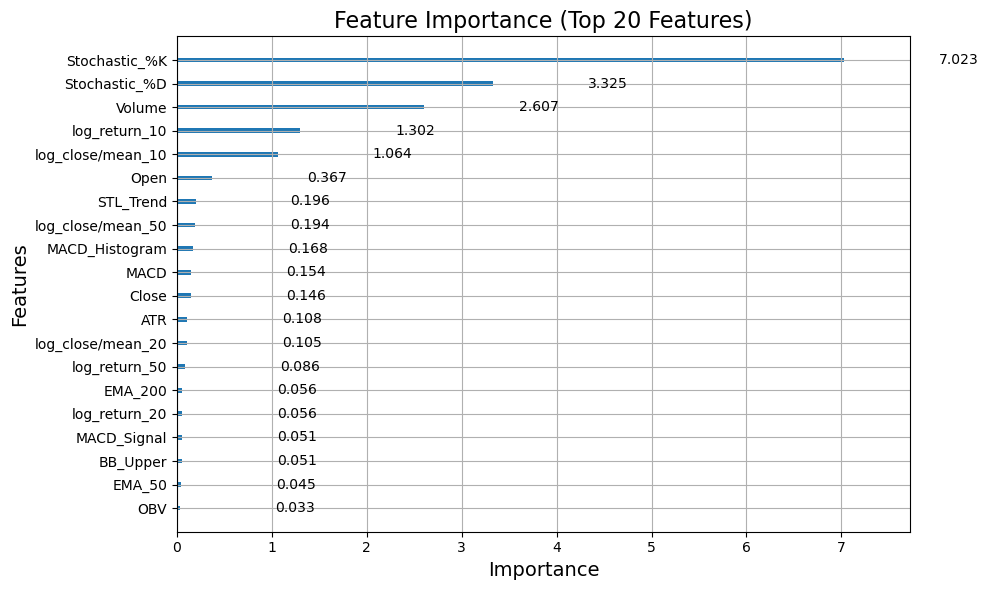

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions on validation set
X_valid = valid_df[features]
y_valid = valid_df['Log_Change']
y_pred = lgb_model.predict(X_valid)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

# Display metrics
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")

plt.figure(figsize=(12, 8))
lgb.plot_importance(lgb_model, max_num_features=20, importance_type='gain', figsize=(10, 6))
plt.title("Feature Importance (Top 20 Features)", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.tight_layout()
plt.show()

Backtesting

In [42]:
X_predict = predict_df[['Volume', 'Open', 'Close', 'High', 'Low', 'STL_Trend', 'STL_Seasonal', 'STL_Residual'] + \
           [f'log_close/mean_{lag}' for lag in lags] + \
           [f'log_return_{lag}' for lag in lags] + \
           [f'mean_close/mean_{lag}' for lag in lags] + \
           [f'mean_log_returns_{lag}' for lag in lags] + \
           [f'log_close/mean_{lag}-mean_close/mean_{lag}' for lag in lags] + \
           [f'log_return_{lag}-mean_log_returns_{lag}' for lag in lags] + \
           ['RSI', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'EMA_50', 'EMA_200', 'ATR', 
            'SMA_20', 'SMA_50', 'OBV', 'Stochastic_%K', 'Stochastic_%D', 'ADX_14', '+DI', '-DI']]
df_pred = predict_df.copy()
df_pred['Predict'] = lgb_model.predict(X_predict)

100%|██████████| 19297/19297 [00:01<00:00, 15055.08it/s]


Total Profits: 0.50%
Max Drawdown: 0.00%
Trade Count: 1
Win Ratio: 1.00
Average Profit per Trade: 0.5002%


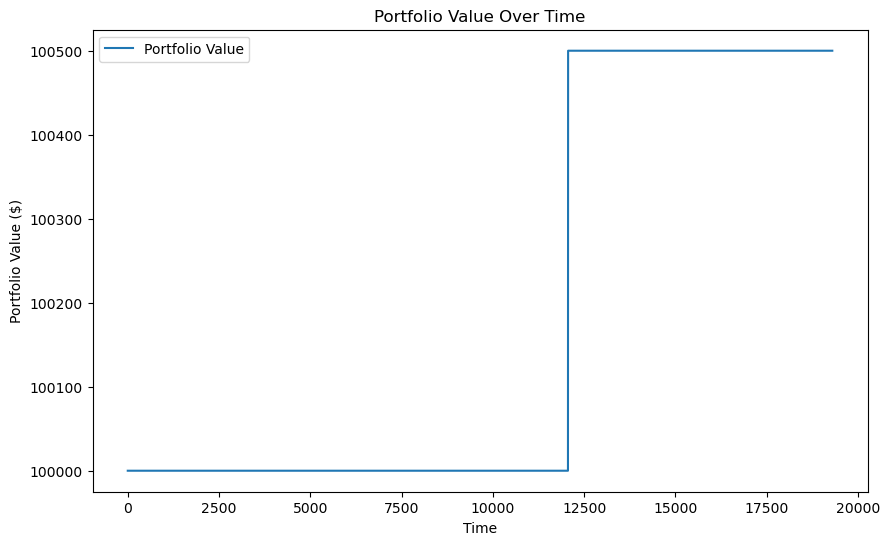

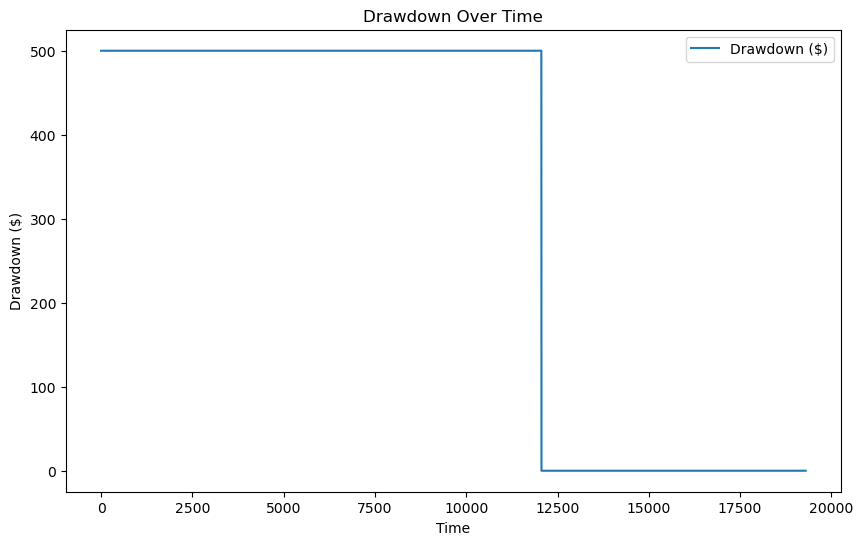

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize backtesting parameters
initial_balance = 100000
trading_balance_ratio = 1
threshold_values = [0.02]
total_profits = []
drawdowns = []
trade_counts = []
win_ratios = []
average_profits = []

df_pred['position'] = 0  # Add a column for positions

# Backtesting loop
for threshold in threshold_values:
    current_balance = initial_balance
    current_position = 0
    entry_price = 0
    trades = []
    portfolio_values = [initial_balance]
    win_trades = 0
    loss_trades = 0
    peak_balance = initial_balance
    max_drawdown = 0

    for i in tqdm(range(len(df_pred))):
        # Entry condition: open a position if no position is held and the prediction exceeds the threshold
        if current_position == 0 and df_pred.iloc[i]['Predict'] > threshold:
            current_position = 1
            entry_price = df_pred.iloc[i]['Close']
            entry_time = df_pred.iloc[i]['Timestamp']
            df_pred.iloc[i, df_pred.columns.get_loc('position')] = 1

        # Exit condition: close the position if the prediction is less than 0
        elif current_position == 1 and df_pred.iloc[i]['Predict'] < 0:
            current_position = 0
            exit_price = df_pred.iloc[i]['Close']
            exit_time = df_pred.iloc[i]['Timestamp']
            df_pred.iloc[i, df_pred.columns.get_loc('position')] = -1
            
            # Adjusted trade return calculation with slippage
            trade_return = (exit_price * 0.99 - entry_price * 1.01) / (entry_price * 1.01)
            trade_profit = trade_return * min(99000, current_balance)
            current_balance += trade_profit
            
            # Calculate trade duration in minutes
            trade_duration = (exit_time - entry_time).total_seconds() / 60  # Time in minutes
            trades.append((entry_price, entry_time, exit_price, exit_time, trade_return, trade_duration, current_balance))
            
            # Track wins and losses
            if trade_profit > 0:
                win_trades += 1
            else:
                loss_trades += 1

        # Track portfolio value
        portfolio_values.append(current_balance)
        peak_balance = max(peak_balance, current_balance)
        drawdown = (peak_balance - current_balance) / peak_balance * 100
        max_drawdown = max(max_drawdown, drawdown)

    # Calculate key metrics
    total_profit = (current_balance - initial_balance) / initial_balance * 100
    average_profit_per_trade = total_profit / len(trades) if trades else 0
    win_ratio = win_trades / len(trades) if trades else 0

    total_profits.append(total_profit)
    drawdowns.append(max_drawdown)
    trade_counts.append(len(trades))
    win_ratios.append(win_ratio)
    average_profits.append(average_profit_per_trade)

# Displaying final performance summary
print(f'Total Profits: {total_profits[-1]:.2f}%')
print(f'Max Drawdown: {drawdowns[-1]:.2f}%')
print(f'Trade Count: {trade_counts[-1]}')
print(f'Win Ratio: {win_ratios[-1]:.2f}')
print(f'Average Profit per Trade: {average_profits[-1]:.4f}%')

# Plot portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(portfolio_values, label='Portfolio Value')
plt.xlabel('Time')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

# Plot drawdown over time
plt.figure(figsize=(10, 6))
drawdown_values = [peak_balance - value for value in portfolio_values]
plt.plot(drawdown_values, label='Drawdown ($)')
plt.xlabel('Time')
plt.ylabel('Drawdown ($)')
plt.title('Drawdown Over Time')
plt.legend()
plt.show()